In [1]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils

from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6413762885963734506
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2204421324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5712997052783535389
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:02:00.0, compute capability: 6.1"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:02:00.0, compute capability: 6.1



In [4]:
train = pd.read_csv('Kaggle/emnist-balanced-train.csv')
test = pd.read_csv('Kaggle/emnist-balanced-test.csv')
mapping = pd.read_csv("Kaggle/emnist-balanced-mapping.txt", 
                      delimiter = ' ', 
                      index_col=0, 
                      header=None, 
                      squeeze=True)

In [5]:
train.shape, test.shape, mapping.shape

((112799, 785), (18799, 785), (47,))

In [6]:
WIDTH = 28
HEIGHT = 28

In [7]:
X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]

del train
del test

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((112799, 784), (112799,), (18799, 784), (18799,))

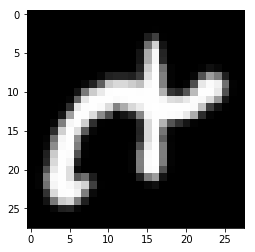

In [9]:
sample = X_train.loc[28]
plt.imshow(sample.values.reshape(28, 28), cmap=plt.cm.gray)
# sample.values, sample.shape

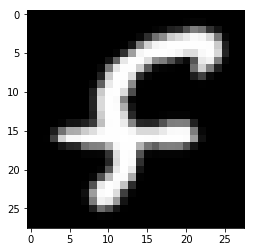

In [10]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

plt.imshow(rotate(sample.values), cmap=plt.cm.gray)

In [11]:
X_train = np.apply_along_axis(rotate, 1, X_train.values)
X_test = np.apply_along_axis(rotate, 1, X_test.values)

In [12]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

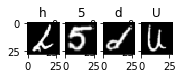

In [13]:
for i in range(100, 104):
    plt.subplot(390 + (i+1))
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.title(chr(mapping[y_train[i]]))
#     print(X_train[i])

In [14]:
number_of_classes = y_train.nunique()

# One Hot Encoding
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

y_train.shape, y_test.shape

((112799, 47), (18799, 47))

In [15]:
# Reshape train image for CNN input
# Tensorflow (batch, width, height, channels)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [16]:
# partition to train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size= 0.10, 
                                                  random_state=88)

## LeNet 5 Architecture
![lenet5structure](https://www.researchgate.net/profile/Yiren_Zhou/publication/312170477/figure/fig1/AS:448817725218816@1484017892071/Structure-of-LeNet-5.png)

In [17]:
# model = Sequential()

# model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
# model.add(layers.AveragePooling2D())

# model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
# model.add(layers.AveragePooling2D())

# model.add(layers.Flatten())

# model.add(layers.Dense(units=120, activation='relu'))

# model.add(layers.Dense(units=84, activation='relu'))

# model.add(layers.Dense(units=47, activation = 'softmax'))

# LeNet-5 Best Submision
# model = Sequential()
# model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
# model.add(layers.MaxPool2D(strides=2))
# model.add(layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
# model.add(layers.MaxPool2D(strides=2))
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(84, activation='relu'))
# model.add(layers.Dense(47, activation='softmax'))

# MNIST top5% 99% acc, rmsprop optimizer
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(47, activation = "softmax"))

## AlexNet

In [18]:
# #Instantiate an empty model
# model = Sequential()

# # 1st Convolutional Layer
# model.add(Conv2D(filters=96, input_shape=(224, 224, 3), kernel_size=(11,11), strides=(4,4), padding='valid'))
# model.add(Activation('relu'))
# # Max Pooling
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# # 2nd Convolutional Layer
# model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
# model.add(Activation('relu'))
# # Max Pooling
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# # 3rd Convolutional Layer
# model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
# model.add(Activation('relu'))

# # 4th Convolutional Layer
# model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
# model.add(Activation('relu'))

# # 5th Convolutional Layer
# model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
# model.add(Activation('relu'))
# # Max Pooling
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# # Passing it to a Fully Connected layer
# model.add(Flatten())
# # 1st Fully Connected Layer
# model.add(Dense(4096, input_shape=(224*224*3,)))
# model.add(Activation('relu'))
# # Add Dropout to prevent overfitting
# model.add(Dropout(0.4))

# # 2nd Fully Connected Layer
# model.add(Dense(4096))
# model.add(Activation('relu'))
# # Add Dropout
# model.add(Dropout(0.4))

# # 3rd Fully Connected Layer
# model.add(Dense(1000))
# model.add(Activation('relu'))
# # Add Dropout
# model.add(Dropout(0.4))

# # Output Layer
# model.add(Dense(47))
# model.add(Activation('softmax'))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)       

In [20]:
optimizer_name = 'sgd'

model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

model_name = optimizer_name

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint(model_name+'.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

In [21]:
history = model.fit(X_train,
                    y_train, 
                    epochs=30, 
                    batch_size=16, 
                    verbose=2, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, mcp_save, TQDMNotebookCallback()])

Train on 101519 samples, validate on 11280 samples


Epoch 1/30


 - 101s - loss: 0.7970 - accuracy: 0.7541 - val_loss: 0.3857 - val_accuracy: 0.8654

Epoch 00001: val_loss improved from inf to 0.38565, saving model to sgd.h5
Epoch 2/30


 - 97s - loss: 0.4715 - accuracy: 0.8398 - val_loss: 0.3417 - val_accuracy: 0.8783

Epoch 00002: val_loss improved from 0.38565 to 0.34169, saving model to sgd.h5
Epoch 3/30


 - 99s - loss: 0.4141 - accuracy: 0.8557 - val_loss: 0.3245 - val_accuracy: 0.8829

Epoch 00003: val_loss improved from 0.34169 to 0.32448, saving model to sgd.h5
Epoch 4/30


 - 99s - loss: 0.3815 - accuracy: 0.8661 - val_loss: 0.3165 - val_accuracy: 0.8841

Epoch 00004: val_loss improved from 0.32448 to 0.31648, saving model to sgd.h5
Epoch 5/30


 - 99s - loss: 0.3635 - accuracy: 0.8698 - val_loss: 0.3104 - val_accuracy: 0.8903

Epoch 00005: val_loss improved from 0.31648 to 0.31035, saving model to sgd.h5
Epoch 6/30


 - 103s - loss: 0.3460 - accuracy: 0.8757 - val_loss: 0.3020 - val_accuracy: 0.8905

Epoch 00006: val_loss improved from 0.31035 to 0.30197, saving model to sgd.h5
Epoch 7/30


 - 103s - loss: 0.3348 - accuracy: 0.8794 - val_loss: 0.3010 - val_accuracy: 0.8916

Epoch 00007: val_loss improved from 0.30197 to 0.30098, saving model to sgd.h5
Epoch 8/30


 - 104s - loss: 0.3273 - accuracy: 0.8817 - val_loss: 0.2957 - val_accuracy: 0.8932

Epoch 00008: val_loss improved from 0.30098 to 0.29567, saving model to sgd.h5
Epoch 9/30


 - 96s - loss: 0.3162 - accuracy: 0.8840 - val_loss: 0.2977 - val_accuracy: 0.8913

Epoch 00009: val_loss did not improve from 0.29567
Epoch 10/30


 - 106s - loss: 0.3101 - accuracy: 0.8862 - val_loss: 0.2896 - val_accuracy: 0.8953

Epoch 00010: val_loss improved from 0.29567 to 0.28964, saving model to sgd.h5
Epoch 11/30


 - 106s - loss: 0.3028 - accuracy: 0.8882 - val_loss: 0.2897 - val_accuracy: 0.8949

Epoch 00011: val_loss did not improve from 0.28964
Epoch 12/30


 - 106s - loss: 0.2986 - accuracy: 0.8904 - val_loss: 0.2825 - val_accuracy: 0.8953

Epoch 00012: val_loss improved from 0.28964 to 0.28252, saving model to sgd.h5
Epoch 13/30


 - 106s - loss: 0.2956 - accuracy: 0.8906 - val_loss: 0.2837 - val_accuracy: 0.8962

Epoch 00013: val_loss did not improve from 0.28252
Epoch 14/30


 - 106s - loss: 0.2871 - accuracy: 0.8932 - val_loss: 0.2814 - val_accuracy: 0.8957

Epoch 00014: val_loss improved from 0.28252 to 0.28139, saving model to sgd.h5
Epoch 15/30


 - 106s - loss: 0.2825 - accuracy: 0.8936 - val_loss: 0.2826 - val_accuracy: 0.8936

Epoch 00015: val_loss did not improve from 0.28139
Epoch 16/30


 - 106s - loss: 0.2780 - accuracy: 0.8954 - val_loss: 0.2797 - val_accuracy: 0.8970

Epoch 00016: val_loss improved from 0.28139 to 0.27967, saving model to sgd.h5
Epoch 17/30


 - 109s - loss: 0.2735 - accuracy: 0.8966 - val_loss: 0.2794 - val_accuracy: 0.8988

Epoch 00017: val_loss improved from 0.27967 to 0.27944, saving model to sgd.h5
Epoch 18/30


 - 105s - loss: 0.2725 - accuracy: 0.8971 - val_loss: 0.2750 - val_accuracy: 0.8986

Epoch 00018: val_loss improved from 0.27944 to 0.27503, saving model to sgd.h5
Epoch 19/30


 - 104s - loss: 0.2685 - accuracy: 0.8984 - val_loss: 0.2807 - val_accuracy: 0.8951

Epoch 00019: val_loss did not improve from 0.27503
Epoch 20/30


 - 98s - loss: 0.2649 - accuracy: 0.8991 - val_loss: 0.2815 - val_accuracy: 0.8965

Epoch 00020: val_loss did not improve from 0.27503
Epoch 21/30


 - 99s - loss: 0.2601 - accuracy: 0.9003 - val_loss: 0.2760 - val_accuracy: 0.9002

Epoch 00021: val_loss did not improve from 0.27503
Epoch 22/30


 - 99s - loss: 0.2604 - accuracy: 0.9002 - val_loss: 0.2741 - val_accuracy: 0.9002

Epoch 00022: val_loss improved from 0.27503 to 0.27408, saving model to sgd.h5
Epoch 23/30


 - 99s - loss: 0.2556 - accuracy: 0.9018 - val_loss: 0.2784 - val_accuracy: 0.8980

Epoch 00023: val_loss did not improve from 0.27408
Epoch 24/30


 - 99s - loss: 0.2521 - accuracy: 0.9023 - val_loss: 0.2778 - val_accuracy: 0.9006

Epoch 00024: val_loss did not improve from 0.27408
Epoch 25/30


 - 99s - loss: 0.2497 - accuracy: 0.9033 - val_loss: 0.2772 - val_accuracy: 0.9004

Epoch 00025: val_loss did not improve from 0.27408
Epoch 26/30


 - 99s - loss: 0.2465 - accuracy: 0.9056 - val_loss: 0.2728 - val_accuracy: 0.8996

Epoch 00026: val_loss improved from 0.27408 to 0.27282, saving model to sgd.h5
Epoch 27/30


 - 99s - loss: 0.2454 - accuracy: 0.9058 - val_loss: 0.2760 - val_accuracy: 0.9003

Epoch 00027: val_loss did not improve from 0.27282
Epoch 28/30


 - 99s - loss: 0.2427 - accuracy: 0.9063 - val_loss: 0.2768 - val_accuracy: 0.8993

Epoch 00028: val_loss did not improve from 0.27282
Epoch 29/30


 - 97s - loss: 0.2407 - accuracy: 0.9064 - val_loss: 0.2763 - val_accuracy: 0.8996

Epoch 00029: val_loss did not improve from 0.27282
Epoch 30/30


 - 97s - loss: 0.2379 - accuracy: 0.9069 - val_loss: 0.2751 - val_accuracy: 0.8987

Epoch 00030: val_loss did not improve from 0.27282



In [22]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [23]:
history.history

{'val_loss': [0.3856549157794063,
  0.3416943185586245,
  0.32448313958044595,
  0.31647764799971106,
  0.3103523919306009,
  0.30196727544188184,
  0.30097702834226775,
  0.29566524568086505,
  0.2976903814426128,
  0.2896439035575018,
  0.2896844527367106,
  0.2825206157487176,
  0.2837024810598463,
  0.28138580754372877,
  0.28256832487379197,
  0.2796668651229735,
  0.2794399673228172,
  0.275033352968567,
  0.28074659460706386,
  0.2815352861967651,
  0.2759536291333906,
  0.27408045078396587,
  0.27836830711375316,
  0.27783929920253336,
  0.2772232069158332,
  0.27281624214155664,
  0.2759734788552878,
  0.2768153233334739,
  0.27625736152779656,
  0.27510584030128643],
 'val_accuracy': [0.8654255270957947,
  0.8782801628112793,
  0.8828900456428528,
  0.8841311931610107,
  0.8903368711471558,
  0.8905141949653625,
  0.8915780186653137,
  0.8931737542152405,
  0.8913120627403259,
  0.8953014016151428,
  0.894946813583374,
  0.8953014016151428,
  0.896187961101532,
  0.8956560492

In [24]:
#%%
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

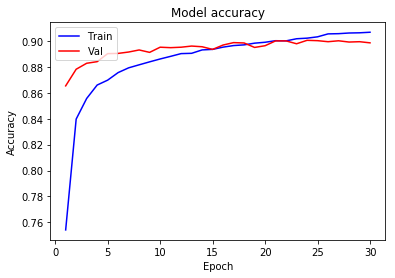

In [25]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

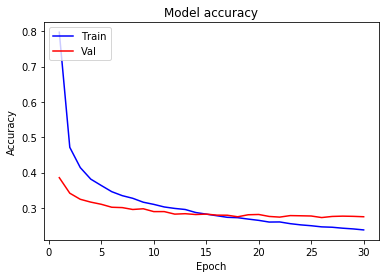

In [26]:
# loss curve
plotgraph(epochs, loss, val_loss)

In [27]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [28]:
y_pred.shape

(18799, 47)

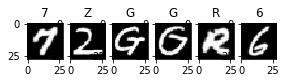

In [29]:
for i in range(10, 16):
    plt.subplot(380 + (i%10+1))
    plt.imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.title(chr(mapping[y_pred[i].argmax()]))

In [30]:
model.save('character_recognizer.h5')

In [31]:
model.evaluate(X_test, y_test)

18799/18799 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 231us/step


[0.28455859390977434, 0.9010053873062134]